In [85]:
# This notebook is used to plot the transmission of the spectrum of a sample

import matplotlib.pyplot as plt
import mcareader as mca
import numpy as np

In [86]:
# can read MCA files directly
raw = mca.Mca("7_12_newBaseline.mca") # raw baseline data
filt = mca.Mca("7_12_withNewMeshNoPoly.mca")   # data with filter/sample

# get exposure time lengths for normalization (in seconds)
raw_exp = float(raw.get_variable("LIVE_TIME"))
filt_exp = float(filt.get_variable("LIVE_TIME"))

# extract just the data
raw = raw.get_points()
filt = filt.get_points()

In [87]:
a=0.04107 # calibration coefficients Energy = a *(channel number) + b, taken from DPPMCA for 6/23/23
b=-0.370

print("Channel", "Energies (keV)")
print(256, a*256+b)
print(1024, a*1024+b)

Channel Energies (keV)
256 10.143920000000001
1024 41.685680000000005


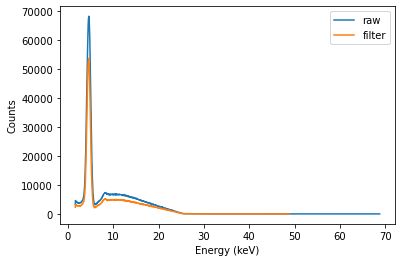

In [88]:
plt.plot(raw[0],raw[1], label="raw")
plt.plot(filt[0],filt[1], label="filter")
plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.legend()
plt.show()

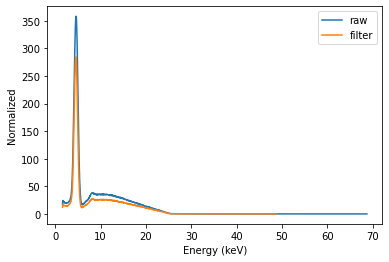

In [89]:
rawNorm = raw[1]/raw_exp
filtNorm = filt[1]/filt_exp

plt.plot(raw[0],rawNorm, label="raw")
plt.plot(filt[0],filtNorm, label="filter")
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized")
plt.legend()
plt.show()

Text(0, 0.5, 'Transmission (1 is full)')

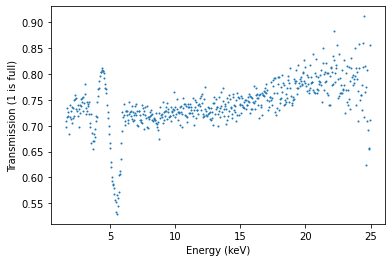

In [93]:
# crop range of data
emin = 0
emax = 25  # keV
imin = np.argmin(np.abs(raw[0]-emin))
imax = np.argmin(np.abs(raw[0]-emax))

xAxis = raw[0][imin:imax]
rawNorm_crop = rawNorm[imin:imax]
filtNorm_crop = filtNorm[imin:imax]

plt.scatter(xAxis, filtNorm_crop/rawNorm_crop, s=1)
plt.xlabel("Energy (keV)")
plt.ylabel("Transmission (1 is full)")

In [91]:
# nonlinear fit to the data (TBD)
# from scipy.optimize import curve_fit